In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox  
from osmnx import geocoder
import matplotlib.animation as animation
import random
import time
import imageio
import networkx as nx
import imageio.v2 as imageio
from io import BytesIO
from multiprocessing import Pool

In [59]:
nodes = pd.read_csv('nodes.csv')
edges = pd.read_csv('edges.csv')
print(nodes)
#fig, ax = ox.plot_graph(G)


             osmid          y          x  street_count   highway  ref railway  \
0           118725  55.673976  12.562910             1       NaN  NaN     NaN   
1           118738  55.662837  12.561835             1       NaN  NaN     NaN   
2           118744  55.661718  12.560034             4       NaN  NaN     NaN   
3           118759  55.657275  12.553866             3       NaN  NaN     NaN   
4           118768  55.652331  12.548202             3       NaN  NaN     NaN   
...            ...        ...        ...           ...       ...  ...     ...   
37108  12572453856  55.715085  12.577400             3       NaN  NaN     NaN   
37109  12572453870  55.715084  12.577364             1  crossing  NaN     NaN   
37110  12572453871  55.715105  12.577399             1       NaN  NaN     NaN   
37111  12572453892  55.715103  12.577940             3       NaN  NaN     NaN   
37112  12587505977  55.653394  12.638703             3       NaN  NaN     NaN   

                           

In [60]:
G = ox.load_graphml('graph.graphml')
print(G)

MultiDiGraph with 37113 nodes and 102980 edges


In [70]:

'''
def visualize_paths_fast(G, population, filename="paths.gif", skip=10):
    frames = []
    pos = nx.spring_layout(G)  # Compute layout for consistent positions
    fig, ax = plt.subplots(figsize=(6, 6))

    for i, path in enumerate(population):
        if i % skip != 0:  # Skip paths to reduce frames (adjust `skip` value as needed)
            continue
        
        ax.clear()

        # Draw base graph
        nx.draw(G, pos, node_color="gray", node_size=50, edge_color="lightgray", ax=ax)
        
        # Draw current path
        edges = [(path[j], path[j + 1]) for j in range(len(path) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="blue", width=2, ax=ax)
        nx.draw_networkx_nodes(G, pos, nodelist=path, node_color="red", node_size=80, ax=ax)
        
        # Display path counter
        ax.text(0.05, 0.95, f"Path {i+1}/{len(population)}", transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

        # Save frame in memory instead of disk
        buf = BytesIO()
        plt.savefig(buf, format="png")
        buf.seek(0)
        frames.append(imageio.imread(buf))
        buf.close()

    imageio.mimsave(filename, frames, duration=0.1)  # Reduced duration for faster GIF
    print(f"GIF saved as {filename}")
'''



def plot_path(G, path):

    route_x, route_y = zip(*[(G.nodes[node]["x"], G.nodes[node]["y"]) for node in path])


    padding = 0.001 
    x_min, x_max = min(route_x) - padding, max(route_x) + padding
    y_min, y_max = min(route_y) - padding, max(route_y) + padding

    fig, ax = plt.subplots(figsize=(8, 8))

    ox.plot_graph(G, ax=ax, show=False, close=False, bgcolor='white')
    ax.plot(route_x[0], route_y[0], color='yellow', linewidth=5, marker='o')
    ax.plot(route_x[-1], route_y[-1], color='yellow', linewidth=5, marker='*')
    ax.plot(route_x, route_y, color='red')
    ax.set_xlim(x_min, x_max) 
    ax.set_ylim(y_min, y_max)
    plt.show()

def plot_multi_path(G, paths):
    fig, ax = plt.subplots(figsize=(8, 8))
    ox.plot_graph(G, ax=ax, show=False, close=False, bgcolor='white')

    colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    for i, path in enumerate(paths):
        route_x, route_y = zip(*[(G.nodes[node]["x"], G.nodes[node]["y"]) for node in path])
        
        color = colors[i % len(colors)]
        
        ax.plot(route_x, route_y, color=color, label=f'Path {i+1}')
    ax.plot(route_x[0], route_y[0], color='yellow', linewidth=5, marker='o')
    ax.plot(route_x[-1], route_y[-1], color='yellow', linewidth=5, marker='*')
    ax.legend()
    ax.set_xlim(min(route_x) - 0.001, max(route_x) + 0.001)
    ax.set_ylim(min(route_y) - 0.001, max(route_y) + 0.001)
    plt.show()

def find_neighbors(G, node_id):
    ''' 
    This function returns a list with the ids of the neighbors of a node.

    Arguments:
        - G: a graph object
        - node_id: the id of the node to find the neighbors of

    Returns:
        - neighbors: a list with the ids of the neighbors of the node

    '''
    neighbors = []
    for neighbor in G.neighbors(node_id):
        neighbors.append(neighbor)

    if len(neighbors) == 0:
        print('Node has no neighbors')
    return np.array(neighbors)


def real_dist_nodes( edges, node1_id, node2_id):
    '''  
    This function returns a the distance between two connected nodes.

    Arguments:
        - edges: edges data frame
        - node1_id: node 1 id
        - node2_id: node 2 id

    Returns:
        - length: length between the connected nodes
    
    '''
    edge = edges[(edges['u'] == node1_id) & (edges['v'] == node2_id)]
    if not edge.empty:
        return edge.iloc[0]['length']
    else:
        print('Nodes are not connected')
        return None 


def euc_dist_nodes(G, edges, node1_id, node2_id):
    y1, x1, y2, x2 = [] , [], [], []

    for i in range(len(node1_id)):
        node_data = G.nodes[node1_id[i]]
        y1.append(node_data['y'])
        x1.append(node_data['x'])
    for j in range(len(node2_id)):
        node_data = G.nodes[node2_id[j]]
        y2.append(node_data['y'])
        x2.append(node_data['x'])
    y1, x1, y2, x2 = np.array(y1), np.array(x1), np.array(y2), np.array(x2)
    distance = ox.distance.euclidean(y1, x1, y2, x2)
    return distance**2
    

def distance_to_prob(dist):
    ''' 
    This function returns the probability of a path given the distance.

    Arguments:
        - dist: distance of the path

    Returns:
        - prob: normalized probability of the path

    '''
    prob = 1/dist
    return prob / np.sum(prob)


def length_population(G, pop):
    fitness = []
    for i in range(len(pop)):
        fitness.append(sum(G[u][v][0]['length'] for u, v in zip(pop[i][:-1], pop[i][1:])))
    return fitness

def find_path(G, edges, nodes, start_id, end_id):
    current_id = start_id
    path = [current_id]

    while current_id != end_id:
        neigh = find_neighbors(G, current_id)
        if len(neigh) == 0:
            #print('No neighbours found, terminating search.')
            break
        dist_to_end = euc_dist_nodes(G, edges, neigh, [end_id])

        if np.any(dist_to_end==0):
            #print('Path found!')
            path.append(end_id)
            break

        prob = distance_to_prob(dist_to_end)

        current_id = np.random.choice(neigh, p=prob)

        path.append(current_id)

    return np.array(path)


def populate(G, edges, nodes, start_id, end_id, num_pop):
    print(f'Populating with {num_pop} paths:')
    population= []
    for n in range(num_pop):
        path = find_path(G, edges, nodes, start_id, end_id)
        population.append(path)
        if n%(num_pop/4) == 0:
            print(f'Found {n} paths.')
    print(f'All {num_pop} paths found! \n')
    print('############### \n')
    return population

def best_survive(population , lengths, fraction) : 
    '''this function is getting a population and the lengths of the paths and returns the best fraction of the population'''
    sorted_indices = np.argsort(lengths)
    sorted_population = [population[i] for i in sorted_indices]

    survivors = int(fraction * len(population))

    survivors_pop = sorted_population[:survivors]
    return survivors_pop

def mutation(G,path):
    mnode = np.random.randint(1, len(path)-2)
    neigh = find_neighbors(G, path[mnode])
    possible_neighbors = [ n for n in neigh if G.has_edge(path[mnode-1], n) and G.has_edge(n, path[mnode+1])]

    if possible_neighbors:
        path[mnode] = random.choice(possible_neighbors)
    return path

def sex(parent1, parent2):
    common = list(set(parent1) & set(parent2))
    cnode = random.choice(common)

    idx1 = int(random.choice(np.where(parent1==cnode)[0]))
    idx2 = int(random.choice(np.where(parent2==cnode)[0]))

    if np.random.randint(0,2) == 0:
        child = np.concatenate((parent1[:idx1], parent2[idx2:]))
    else:
        child = np.concatenate((parent2[:idx2], parent1[idx1:]))
    
    if np.random.randint(0,101) < 10:
        child = mutation(G, child)

    return child

def parallel_length_population(G, population):
    def path_length(path):
        return sum(G[u][v][0]['length'] for u, v in zip(path[:-1], path[1:]))
    
    with Pool() as pool:
        fitness = pool.map(path_length, population)
    
    return np.array(fitness)

def evolution(nodestart, nodeend, generations, fraction, population_size, G=G, edges=edges, nodes=nodes):
    """This function performs a genetic algorithm to find the best path between two nodes and generates a GIF."""
    control = False
    convergency_generations = 10
    best_length = []
    survivors_pop = []
    population = populate(G, edges, nodes, nodestart, nodeend, population_size)
    lengths = length_population(G, population)
    survivors_pop= best_survive(population, lengths, fraction)
    best_length.append(min(lengths))
    padding = 0.005
    nodestartd = G.nodes[nodestart]
    nodeendd = G.nodes[nodeend]
    x_min, x_max = min([nodestartd['x'],nodeendd['x']]) - padding, max([nodestartd['x'],nodeendd['x']]) + padding
    y_min, y_max = min([nodestartd['y'],nodeendd['y']]) - padding, max([nodestartd['y'],nodeendd['y']]) + padding
    
    for gen in range(generations):
        start = time.time()
        population = survivors_pop 
        while population_size > len(population):
            parent1, parent2 = random.sample(survivors_pop, 2)
            population.append(sex(parent1, parent2))
        
        lengths = length_population(G, population)
        survivors_pop = best_survive(population, lengths, fraction)
        best_length.append(min(lengths))
        
        best_path = survivors_pop[0]

        fig, ax = plt.subplots(figsize=(8, 8))
        ox.plot_graph(G, ax=ax, show=False, close=False, bgcolor='white')
        route_x, route_y = zip(*[(G.nodes[node]["x"], G.nodes[node]["y"]) for node in best_path])
        ax.plot(route_x, route_y, color='red', linewidth=2)
        ax.plot(route_x[0], route_y[0], color='yellow', linewidth=5, marker='o')
        ax.plot(route_x[-1], route_y[-1], color='yellow', linewidth=5, marker='*')
        ax.text(0.05, 0.95, f"Generation {gen+1}/{generations}", transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
        ax.set_xlim(x_min, x_max) 
        ax.set_ylim(y_min, y_max)
        plt.savefig(f'gifs/Path_gen{gen}.png')
        plt.close(fig)
        
        print('Generation', gen+1, "time for it :", time.time()-start)
        print('Best length', best_length[-1])
        
        if len(best_length) > convergency_generations:
            if all(best_length[-i] == best_length[-i-1] for i in range(1, convergency_generations)):
                control = True
        
        if control: 
            print("Convergency reached")
            break
    
    best_path = survivors_pop[0]
    print("GIF saved as best_paths.gif")
    return best_path, best_length

Populating with 100 paths:
Found 0 paths.
Found 25 paths.
Found 50 paths.
Found 75 paths.
All 100 paths found! 

############### 

Generation 1 time for it : 4.498732089996338
Best length 22346.344940708936
Generation 2 time for it : 3.7290852069854736
Best length 22346.344940708936
Generation 3 time for it : 4.0611419677734375
Best length 22346.344940708936
Generation 4 time for it : 3.9343650341033936
Best length 22346.344940708936
Generation 5 time for it : 3.563591957092285
Best length 22171.80376487538
Generation 6 time for it : 3.984221935272217
Best length 12103.108155418064
Generation 7 time for it : 4.0837671756744385
Best length 11550.229712396074
Generation 8 time for it : 3.6939072608947754
Best length 11550.229712396074
Generation 9 time for it : 4.07945990562439
Best length 11550.229712396074
Generation 10 time for it : 3.5266120433807373
Best length 11550.229712396074
Generation 11 time for it : 4.04902195930481
Best length 11550.229712396074
Generation 12 time for it : 

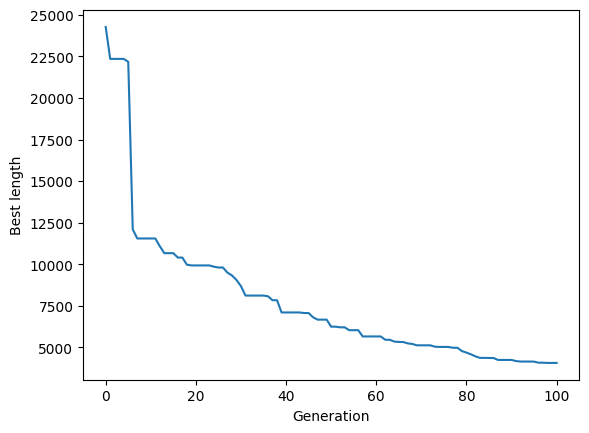

In [71]:
latstart, lonstart = ox.geocoder.geocode('Jagtvej 155, 2200 København, Danmark')
nodestart = ox.distance.nearest_nodes(G, lonstart, latstart)
latend, lonend = ox.geocoder.geocode('Nørregade 10, 1172 København, Danmark')
nodeend = ox.distance.nearest_nodes(G, lonend, latend)


best_path, best_lengths = evolution(nodestart, nodeend, 100, 0.7, 100)
plt.plot(best_lengths)
plt.xlabel('Generation')
plt.ylabel('Best length')
plt.show()

